# The TLC trip record data

Data source: http://www.nyc.gov/html/tlc/html/about/trip_record_data.shtml  

This notebook heavily borrows from https://www.kaggle.com/kartikkannapur/nyc-taxi-trips-exploratory-data-analysis/  

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import graphviz 

import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Please, download the train and tests data sets from the [original Kaggle competition](https://www.kaggle.com/c/nyc-taxi-trip-duration/data) and move them into a folder "data" in the current directory.

In [23]:
# read data from csv
df_train = pd.read_csv("../week2/data/train.csv")

In [24]:
# Make a selection in the pandas data frame by "trip_duration"
df_train_clean = df_train[df_train['trip_duration'] < 3600].copy()

In [25]:
# Define manually geo box for New York as in the picture
nyc_max_long, nyc_min_long = [-73.95, -74.03]
nyc_max_lat, nyc_min_lat = [40.85, 40.65,]

In [26]:
# Select only the data within the box of New York
cond_long = (df_train_clean["pickup_longitude"] > nyc_min_long) & (df_train_clean["pickup_longitude"] < nyc_max_long)
cond_lat = (df_train_clean["pickup_latitude"] > nyc_min_lat) & (df_train_clean["pickup_latitude"] < nyc_max_lat)
df_train_sel = df_train_clean[cond_long & cond_lat].copy()

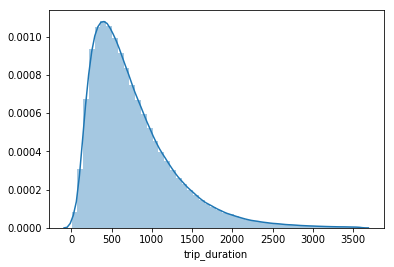

In [27]:
# Visualize distribution of selected training set
sns.distplot(df_train_sel['trip_duration'])

In [28]:
df_train_sample = df_train_sel.sample(frac=0.10)

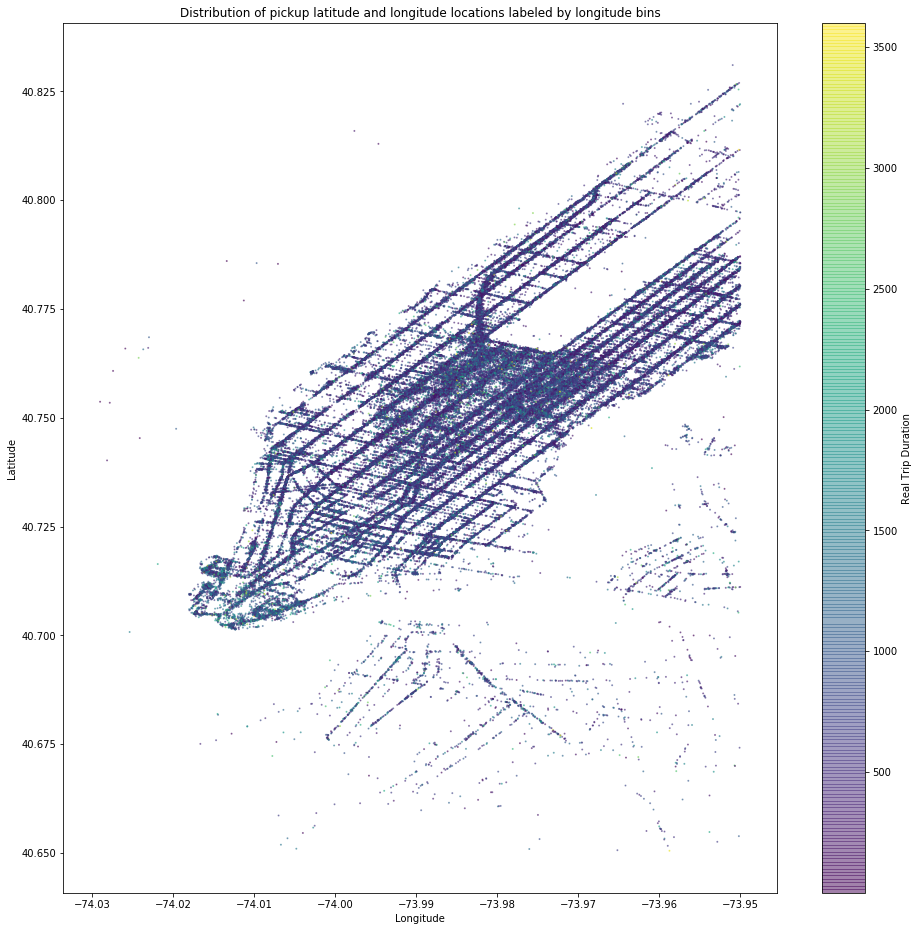

In [29]:
# Visualize distribution of bins for longitude
plt.figure(figsize=(16, 16))
plt.scatter(df_train_sample["pickup_longitude"], df_train_sample["pickup_latitude"], 
            c=df_train_sample['trip_duration'] ,alpha=0.5, s=1)
plt.title("Distribution of pickup latitude and longitude locations labeled by longitude bins")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
cbar = plt.colorbar()
cbar.ax.set_ylabel(f'Real Trip Duration')
plt.show()

In [30]:
X, y = df_train_sample[["pickup_longitude", "pickup_latitude"]], df_train_sample['trip_duration']

# Split all our data into train and tests where the test is only 20% of the whole data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
X_train.size

211398

In [31]:
def make_tree(max_depth, min_samples_leaf):
    # fit the model
    tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    tree.fit(X_train, y_train)
    
    # predict time for training set
    y_pred = tree.predict(X_train)

    # visualize distribution of bins for longitude
    plt.figure(figsize=(12, 12))
    plt.scatter(X_train["pickup_longitude"], X_train["pickup_latitude"], c=y_pred ,alpha=0.5, s=1)
    plt.title(f"Decsision Tree with max depth of {max_depth} and min sample in leafs of {min_samples_leaf}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f'Predicted Trip Duration')
    plt.show()

In [32]:
interact(make_tree, max_depth=widgets.IntSlider(min=1,max=50,step=1,value=2, continuous_update=False), min_samples_leaf=widgets.IntSlider(min=5,max=100,step=5,value=5, continuous_update=False));

interactive(children=(IntSlider(value=2, continuous_update=False, description='max_depth', max=50, min=1), IntSlider(value=5, continuous_update=False, description='min_samples_leaf', min=5, step=5), Output()), _dom_classes=('widget-interact',))

In [33]:
def fit_and_score(max_depth, min_samples_leaf):
    tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    tree.fit(X_train, y_train)
    y_train_pred = tree.predict(X_train)
    y_test_pred = tree.predict(X_test)
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    return {'rmse_train': rmse_train, 'rmse_test': rmse_test} 

In [34]:
scores = {max_depth: fit_and_score(max_depth, 50) for max_depth in range(2, 20)}

In [35]:
scores = pd.DataFrame.from_dict(scores).T.stack().to_frame().reset_index()
scores.columns = ['max_depth', 'measue', 'value']

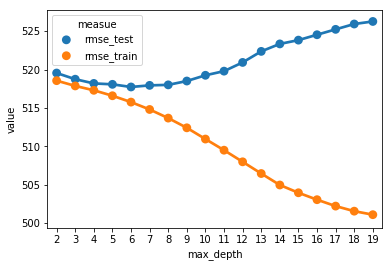

In [36]:
sns.pointplot(data=scores, x='max_depth', y='value', hue='measue')

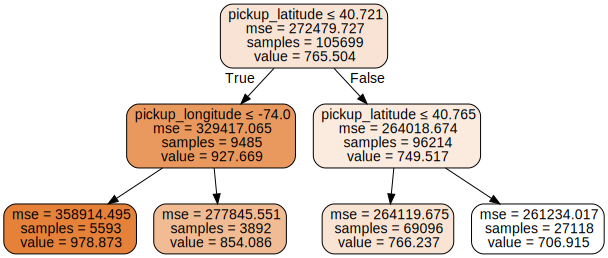

In [46]:
tree = DecisionTreeRegressor(max_depth=2, min_samples_leaf=50)
tree.fit(X_train, y_train)
dot_data = export_graphviz(tree, out_file=None, 
                         feature_names=X_train.columns,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

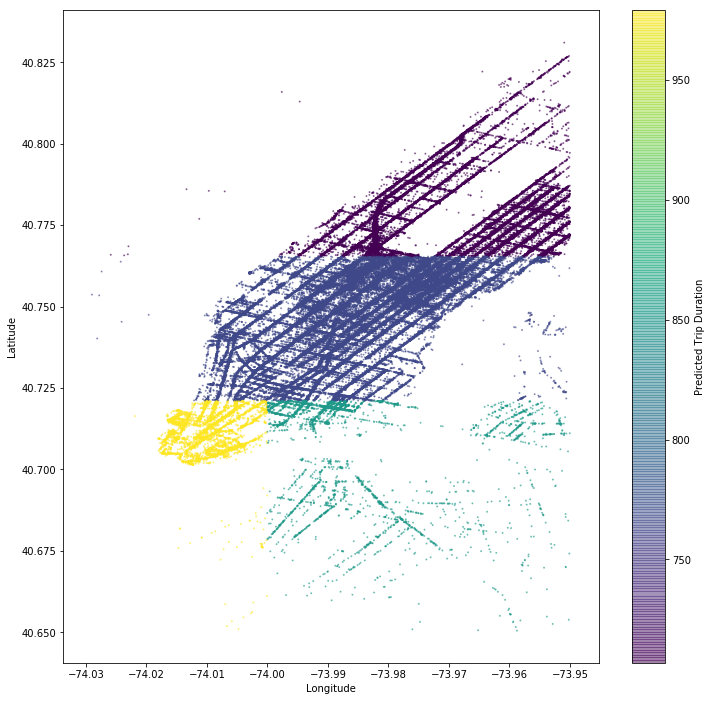

In [48]:
    # predict time for training set
    y_pred = tree.predict(X_train)

    # visualize distribution of bins for longitude
    plt.figure(figsize=(12, 12))
    plt.scatter(X_train["pickup_longitude"], X_train["pickup_latitude"], c=y_pred ,alpha=0.5, s=1)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    cbar = plt.colorbar()
    cbar.ax.set_ylabel(f'Predicted Trip Duration')
    plt.show()